In [1]:
import os
import zipfile
import urllib.request

# Define dataset URL from GitHub
dataset_url = "https://github.com/bochendong/few_shot_classification/archive/refs/heads/main.zip"
dataset_zip_path = "/content/pokemon_dataset.zip"
dataset_folder = "/content/pokemon_dataset"

# Download dataset
if not os.path.exists(dataset_zip_path):
    print("Downloading Pokémon dataset...")
    urllib.request.urlretrieve(dataset_url, dataset_zip_path)

# Extract dataset
if not os.path.exists(dataset_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
        zip_ref.extractall("/content")

print("Dataset ready!")


Extracting dataset...
Dataset ready!


In [2]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define dataset path (Change if needed)
dataset_path = "/content/few_shot_classification-main/PokemonData"

# Define image size for high-resolution training
image_size = 128

# Transformations: Resize, Normalize, Augment
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1,1]
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"Loaded {len(dataset)} images for training.")


Loaded 6820 images for training.


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Latent vector size
nz = 512
nc = 3  # RGB images
ngf = 256  # Generator feature maps
ndf = 256  # Discriminator feature maps


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),  # Output: (ngf*16) x 4 x 4
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # 32x32
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),  # 64x64
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # 128x128
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # 128x128 -> 64x64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 64x64 -> 32x32
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 32x32 -> 16x16
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # 16x16 -> 8x8
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),  # 8x8 -> 4x4
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),  # 4x4 -> 1x1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(input.size(0), 1)  # Ensures output shape is (batch_size, 1)



# Initialize models
latent_dim = 512
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
lr_G = 0.0001
lr_D = 0.0002
beta1 = 0.5

# Create batch of latent vectors for visualization
fixed_noise = torch.randn(64, nz, 1, 1, device="cuda")

optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=(beta1, 0.999))


In [47]:
test_noise = torch.randn(8, nz, 1, 1).to("cuda")  # Generate noise
test_fake_images = generator(test_noise)
print("Generator output shape:", test_fake_images.shape)


Generator output shape: torch.Size([8, 3, 128, 128])


In [48]:
test_input = torch.randn(8, 3, 128, 128).to("cuda")  # Fake Pokémon images
test_output = discriminator(test_input)
print("Discriminator output shape:", test_output.shape)


Discriminator output shape: torch.Size([8, 1])


In [49]:
for images, _ in dataloader:
    print(f"Batch image shape: {images.shape}")
    break


Batch image shape: torch.Size([64, 3, 128, 128])


In [55]:
# Function to display generated images
def show_generated_images(epoch):
    fake_samples = generator(torch.randn(16, latent_dim, 1, 1, device=device)).detach().cpu()
    grid = vutils.make_grid(fake_samples, normalize=True)
    npimg = grid.numpy()
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"Generated Images at Epoch {epoch}")
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

Epoch 0/300, Step 0, Loss D: 1.7768408060073853, Loss G: 1.3031644821166992
Epoch 0/300, Step 50, Loss D: 0.7436577677726746, Loss G: 2.211184501647949
Epoch 0/300, Step 100, Loss D: 1.4002567529678345, Loss G: 1.551615834236145


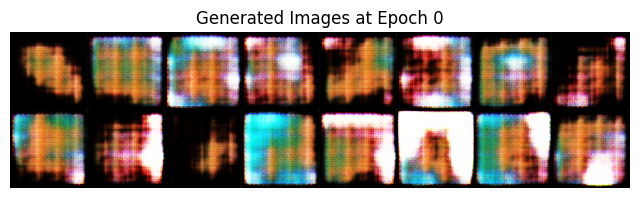

Epoch 1/300, Step 0, Loss D: 0.9528355002403259, Loss G: 1.739051103591919
Epoch 1/300, Step 50, Loss D: 1.4754071235656738, Loss G: 1.8552770614624023
Epoch 1/300, Step 100, Loss D: 1.3953981399536133, Loss G: 3.229691505432129
Epoch 2/300, Step 0, Loss D: 1.0083080530166626, Loss G: 1.6964876651763916
Epoch 2/300, Step 50, Loss D: 1.2180390357971191, Loss G: 1.0850389003753662
Epoch 2/300, Step 100, Loss D: 1.2833402156829834, Loss G: 0.8190891146659851
Epoch 3/300, Step 0, Loss D: 1.276191234588623, Loss G: 1.5703160762786865
Epoch 3/300, Step 50, Loss D: 1.4427779912948608, Loss G: 0.7924352288246155
Epoch 3/300, Step 100, Loss D: 1.1695475578308105, Loss G: 1.4604473114013672
Epoch 4/300, Step 0, Loss D: 1.0018067359924316, Loss G: 1.658963918685913
Epoch 4/300, Step 50, Loss D: 2.879868507385254, Loss G: 1.157344102859497
Epoch 4/300, Step 100, Loss D: 1.2747831344604492, Loss G: 2.1116766929626465
Epoch 5/300, Step 0, Loss D: 1.1555087566375732, Loss G: 1.1496601104736328
Epoch 

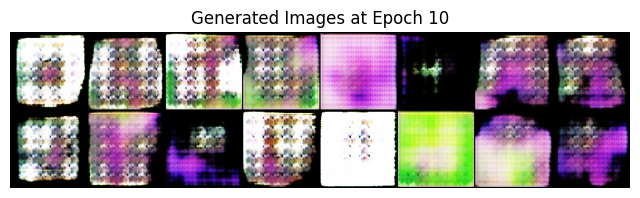

Epoch 11/300, Step 0, Loss D: 0.9025202989578247, Loss G: 2.895587682723999
Epoch 11/300, Step 50, Loss D: 0.9297415018081665, Loss G: 1.608712911605835
Epoch 11/300, Step 100, Loss D: 1.4755568504333496, Loss G: 0.8304517269134521
Epoch 12/300, Step 0, Loss D: 0.8199118375778198, Loss G: 2.131695032119751
Epoch 12/300, Step 50, Loss D: 2.0717318058013916, Loss G: 0.9402173757553101
Epoch 12/300, Step 100, Loss D: 1.3852953910827637, Loss G: 4.364645004272461
Epoch 13/300, Step 0, Loss D: 1.0927343368530273, Loss G: 2.1163511276245117
Epoch 13/300, Step 50, Loss D: 0.8852647542953491, Loss G: 2.4060957431793213
Epoch 13/300, Step 100, Loss D: 0.943009078502655, Loss G: 2.8950517177581787
Epoch 14/300, Step 0, Loss D: 1.9428250789642334, Loss G: 5.289098262786865
Epoch 14/300, Step 50, Loss D: 0.8057999610900879, Loss G: 2.347541332244873
Epoch 14/300, Step 100, Loss D: 1.1185245513916016, Loss G: 1.8280510902404785
Epoch 15/300, Step 0, Loss D: 0.8721929788589478, Loss G: 2.25120329856

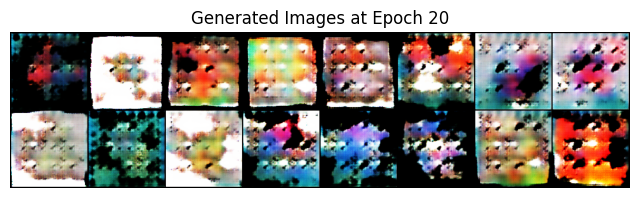

Epoch 21/300, Step 0, Loss D: 1.6571542024612427, Loss G: 4.589979648590088
Epoch 21/300, Step 50, Loss D: 0.9594007730484009, Loss G: 1.6536970138549805
Epoch 21/300, Step 100, Loss D: 1.433110237121582, Loss G: 5.454112529754639
Epoch 22/300, Step 0, Loss D: 0.9723520874977112, Loss G: 2.8908050060272217
Epoch 22/300, Step 50, Loss D: 1.0824055671691895, Loss G: 3.8321237564086914
Epoch 22/300, Step 100, Loss D: 1.0219905376434326, Loss G: 2.136096477508545
Epoch 23/300, Step 0, Loss D: 0.8244069814682007, Loss G: 1.8017406463623047
Epoch 23/300, Step 50, Loss D: 0.7679386138916016, Loss G: 1.8440799713134766
Epoch 23/300, Step 100, Loss D: 1.0723109245300293, Loss G: 2.3514833450317383
Epoch 24/300, Step 0, Loss D: 0.9801501035690308, Loss G: 1.0529881715774536
Epoch 24/300, Step 50, Loss D: 0.8496658802032471, Loss G: 1.4541049003601074
Epoch 24/300, Step 100, Loss D: 0.9956122040748596, Loss G: 4.144131183624268
Epoch 25/300, Step 0, Loss D: 0.833282470703125, Loss G: 2.6272635459

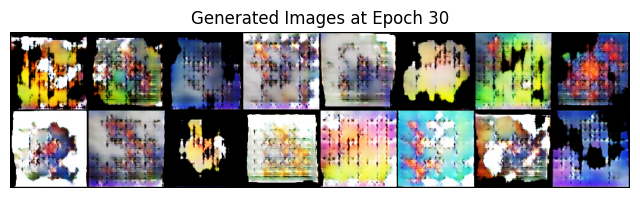

Epoch 31/300, Step 0, Loss D: 1.2540866136550903, Loss G: 0.8839124441146851
Epoch 31/300, Step 50, Loss D: 0.9658901691436768, Loss G: 1.2111033201217651
Epoch 31/300, Step 100, Loss D: 1.4454872608184814, Loss G: 1.3881585597991943
Epoch 32/300, Step 0, Loss D: 1.0289387702941895, Loss G: 2.1615381240844727
Epoch 32/300, Step 50, Loss D: 1.0072872638702393, Loss G: 2.4409050941467285
Epoch 32/300, Step 100, Loss D: 0.8189491033554077, Loss G: 2.786240577697754
Epoch 33/300, Step 0, Loss D: 1.2232277393341064, Loss G: 3.3736395835876465
Epoch 33/300, Step 50, Loss D: 0.8559783101081848, Loss G: 3.056995391845703
Epoch 33/300, Step 100, Loss D: 1.290848731994629, Loss G: 1.9149413108825684
Epoch 34/300, Step 0, Loss D: 0.9930353164672852, Loss G: 2.4462146759033203
Epoch 34/300, Step 50, Loss D: 0.8573507070541382, Loss G: 2.500314712524414
Epoch 34/300, Step 100, Loss D: 0.9202207922935486, Loss G: 1.0977729558944702
Epoch 35/300, Step 0, Loss D: 0.8000442981719971, Loss G: 2.50772571

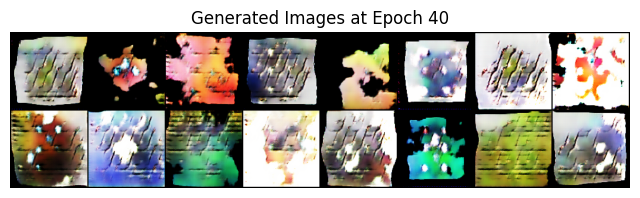

Epoch 41/300, Step 0, Loss D: 0.929172158241272, Loss G: 1.5913280248641968
Epoch 41/300, Step 50, Loss D: 0.8716901540756226, Loss G: 2.6330461502075195
Epoch 41/300, Step 100, Loss D: 0.8893005847930908, Loss G: 2.6538267135620117
Epoch 42/300, Step 0, Loss D: 1.006652593612671, Loss G: 1.1135213375091553
Epoch 42/300, Step 50, Loss D: 0.8055248260498047, Loss G: 2.356971263885498
Epoch 42/300, Step 100, Loss D: 0.8771966099739075, Loss G: 1.9556262493133545
Epoch 43/300, Step 0, Loss D: 0.8053736090660095, Loss G: 2.026358127593994
Epoch 43/300, Step 50, Loss D: 0.7720727920532227, Loss G: 1.7222135066986084
Epoch 43/300, Step 100, Loss D: 0.7933706045150757, Loss G: 2.319283962249756
Epoch 44/300, Step 0, Loss D: 1.314170002937317, Loss G: 4.079044342041016
Epoch 44/300, Step 50, Loss D: 0.7646609544754028, Loss G: 2.064973831176758
Epoch 44/300, Step 100, Loss D: 0.8144814968109131, Loss G: 1.6869455575942993
Epoch 45/300, Step 0, Loss D: 1.279773235321045, Loss G: 0.4630098044872

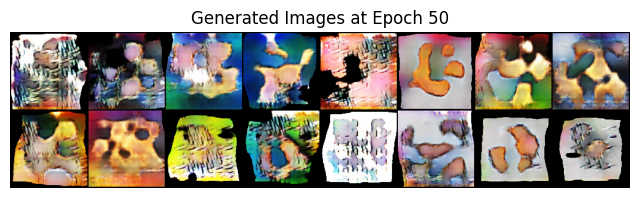

Epoch 51/300, Step 0, Loss D: 0.747000515460968, Loss G: 2.285597324371338
Epoch 51/300, Step 50, Loss D: 0.9611260890960693, Loss G: 3.3184311389923096
Epoch 51/300, Step 100, Loss D: 1.4150290489196777, Loss G: 1.8084161281585693
Epoch 52/300, Step 0, Loss D: 1.0508368015289307, Loss G: 2.370513439178467
Epoch 52/300, Step 50, Loss D: 1.2017021179199219, Loss G: 5.050036430358887
Epoch 52/300, Step 100, Loss D: 0.9526487588882446, Loss G: 4.103683948516846
Epoch 53/300, Step 0, Loss D: 0.7956801652908325, Loss G: 3.339594841003418
Epoch 53/300, Step 50, Loss D: 1.1998896598815918, Loss G: 2.1410093307495117
Epoch 53/300, Step 100, Loss D: 0.9402778148651123, Loss G: 3.5814971923828125
Epoch 54/300, Step 0, Loss D: 0.7355234026908875, Loss G: 2.082695484161377
Epoch 54/300, Step 50, Loss D: 0.8186254501342773, Loss G: 2.692739486694336
Epoch 54/300, Step 100, Loss D: 0.8478060364723206, Loss G: 3.5863449573516846
Epoch 55/300, Step 0, Loss D: 0.7179229855537415, Loss G: 2.629464626312

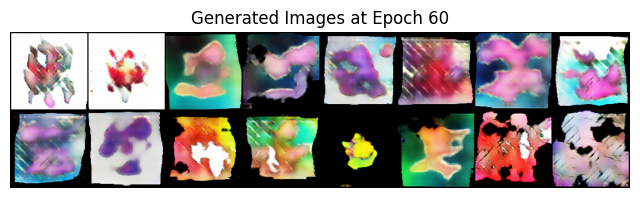

Epoch 61/300, Step 0, Loss D: 0.755649745464325, Loss G: 2.082813262939453
Epoch 61/300, Step 50, Loss D: 0.6812373995780945, Loss G: 2.769759178161621
Epoch 61/300, Step 100, Loss D: 0.716928243637085, Loss G: 2.5957608222961426
Epoch 62/300, Step 0, Loss D: 0.7799927592277527, Loss G: 0.9374842643737793
Epoch 62/300, Step 50, Loss D: 0.757583737373352, Loss G: 1.5319809913635254
Epoch 62/300, Step 100, Loss D: 0.8335824608802795, Loss G: 1.6250436305999756
Epoch 63/300, Step 0, Loss D: 0.7125660181045532, Loss G: 2.4166970252990723
Epoch 63/300, Step 50, Loss D: 0.8810521364212036, Loss G: 1.3962645530700684
Epoch 63/300, Step 100, Loss D: 0.9826552271842957, Loss G: 1.7529172897338867
Epoch 64/300, Step 0, Loss D: 0.7103105783462524, Loss G: 2.3527028560638428
Epoch 64/300, Step 50, Loss D: 0.8802934885025024, Loss G: 3.5933430194854736
Epoch 64/300, Step 100, Loss D: 0.9012914299964905, Loss G: 1.1738173961639404
Epoch 65/300, Step 0, Loss D: 0.7085943222045898, Loss G: 2.254747867

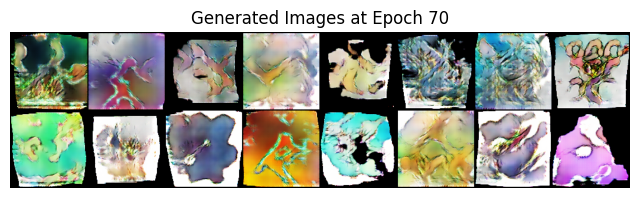

Epoch 71/300, Step 0, Loss D: 0.9417908191680908, Loss G: 3.7668440341949463
Epoch 71/300, Step 50, Loss D: 0.8438978791236877, Loss G: 2.4473910331726074
Epoch 71/300, Step 100, Loss D: 1.0428601503372192, Loss G: 4.099762916564941
Epoch 72/300, Step 0, Loss D: 1.1279759407043457, Loss G: 4.249368190765381
Epoch 72/300, Step 50, Loss D: 0.7401930093765259, Loss G: 1.9558196067810059
Epoch 72/300, Step 100, Loss D: 0.8435555696487427, Loss G: 1.149914264678955
Epoch 73/300, Step 0, Loss D: 0.9915400743484497, Loss G: 3.9860081672668457
Epoch 73/300, Step 50, Loss D: 1.0018823146820068, Loss G: 4.115379333496094
Epoch 73/300, Step 100, Loss D: 0.7310377359390259, Loss G: 2.430109977722168
Epoch 74/300, Step 0, Loss D: 0.7833037376403809, Loss G: 2.059680938720703
Epoch 74/300, Step 50, Loss D: 0.89188551902771, Loss G: 1.3500704765319824
Epoch 74/300, Step 100, Loss D: 0.7264262437820435, Loss G: 2.307948112487793
Epoch 75/300, Step 0, Loss D: 0.8292528390884399, Loss G: 1.1145515441894

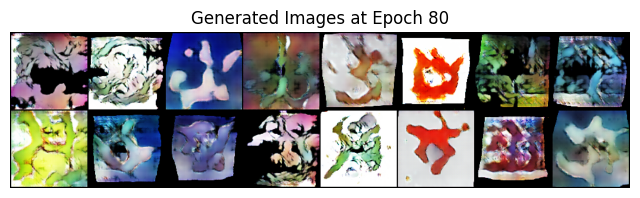

Epoch 81/300, Step 0, Loss D: 0.9871103763580322, Loss G: 0.6194414496421814
Epoch 81/300, Step 50, Loss D: 0.7252760529518127, Loss G: 1.8577044010162354
Epoch 81/300, Step 100, Loss D: 0.7175643444061279, Loss G: 1.9296889305114746
Epoch 82/300, Step 0, Loss D: 0.7217841148376465, Loss G: 2.7004804611206055
Epoch 82/300, Step 50, Loss D: 0.7143253087997437, Loss G: 2.0526695251464844
Epoch 82/300, Step 100, Loss D: 0.6822205781936646, Loss G: 2.4554710388183594
Epoch 83/300, Step 0, Loss D: 0.7574474811553955, Loss G: 2.6228673458099365
Epoch 83/300, Step 50, Loss D: 0.710849404335022, Loss G: 1.7714923620224
Epoch 83/300, Step 100, Loss D: 1.212925910949707, Loss G: 0.7657761573791504
Epoch 84/300, Step 0, Loss D: 0.7321252822875977, Loss G: 2.5452797412872314
Epoch 84/300, Step 50, Loss D: 0.7055296897888184, Loss G: 2.1368818283081055
Epoch 84/300, Step 100, Loss D: 0.7804369926452637, Loss G: 3.4741532802581787
Epoch 85/300, Step 0, Loss D: 0.8246860504150391, Loss G: 3.126374244

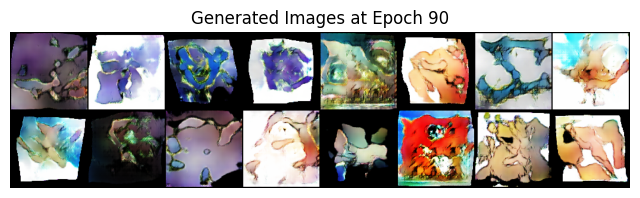

Epoch 91/300, Step 0, Loss D: 0.7550410032272339, Loss G: 1.7647851705551147
Epoch 91/300, Step 50, Loss D: 0.7194798588752747, Loss G: 1.7207218408584595
Epoch 91/300, Step 100, Loss D: 0.7162411212921143, Loss G: 2.1019132137298584
Epoch 92/300, Step 0, Loss D: 0.7076691389083862, Loss G: 2.105191946029663
Epoch 92/300, Step 50, Loss D: 0.8456268310546875, Loss G: 1.7576792240142822
Epoch 92/300, Step 100, Loss D: 0.7222371101379395, Loss G: 2.4276344776153564
Epoch 93/300, Step 0, Loss D: 0.732109010219574, Loss G: 2.9939489364624023
Epoch 93/300, Step 50, Loss D: 0.7029879093170166, Loss G: 1.8831605911254883
Epoch 93/300, Step 100, Loss D: 0.7269904613494873, Loss G: 2.5343809127807617
Epoch 94/300, Step 0, Loss D: 1.0112113952636719, Loss G: 4.457147598266602
Epoch 94/300, Step 50, Loss D: 0.6951887607574463, Loss G: 2.1903481483459473
Epoch 94/300, Step 100, Loss D: 0.9954942464828491, Loss G: 3.5504701137542725
Epoch 95/300, Step 0, Loss D: 0.8914972543716431, Loss G: 2.6467113

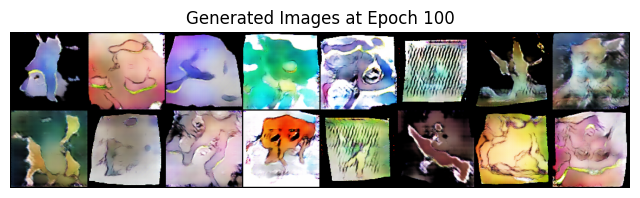

Epoch 101/300, Step 0, Loss D: 0.6731033325195312, Loss G: 1.967848539352417
Epoch 101/300, Step 50, Loss D: 1.0812160968780518, Loss G: 1.493218183517456
Epoch 101/300, Step 100, Loss D: 0.6869041919708252, Loss G: 2.3068647384643555
Epoch 102/300, Step 0, Loss D: 1.2569035291671753, Loss G: 4.688007831573486
Epoch 102/300, Step 50, Loss D: 0.7404651641845703, Loss G: 1.606810450553894
Epoch 102/300, Step 100, Loss D: 0.7234562039375305, Loss G: 2.3848800659179688
Epoch 103/300, Step 0, Loss D: 0.7570022344589233, Loss G: 2.8949036598205566
Epoch 103/300, Step 50, Loss D: 0.8290355205535889, Loss G: 2.628330707550049
Epoch 103/300, Step 100, Loss D: 0.6946803331375122, Loss G: 2.171999454498291
Epoch 104/300, Step 0, Loss D: 0.7139490842819214, Loss G: 2.2605865001678467
Epoch 104/300, Step 50, Loss D: 0.8482131958007812, Loss G: 2.8804945945739746
Epoch 104/300, Step 100, Loss D: 0.8772604465484619, Loss G: 2.733363628387451
Epoch 105/300, Step 0, Loss D: 0.71762615442276, Loss G: 2.

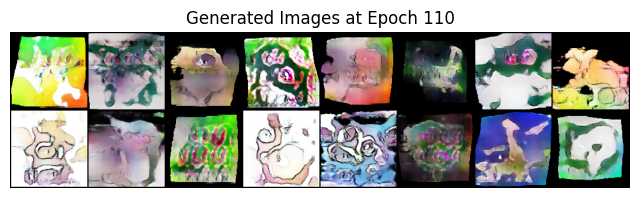

Epoch 111/300, Step 0, Loss D: 1.1042513847351074, Loss G: 4.611937522888184
Epoch 111/300, Step 50, Loss D: 0.733487606048584, Loss G: 2.3266735076904297
Epoch 111/300, Step 100, Loss D: 0.9553638696670532, Loss G: 0.5099600553512573
Epoch 112/300, Step 0, Loss D: 0.7877148389816284, Loss G: 3.246279001235962
Epoch 112/300, Step 50, Loss D: 0.6925634741783142, Loss G: 2.408435344696045
Epoch 112/300, Step 100, Loss D: 0.6966402530670166, Loss G: 2.416675090789795
Epoch 113/300, Step 0, Loss D: 0.685806393623352, Loss G: 1.7367987632751465
Epoch 113/300, Step 50, Loss D: 0.7853348255157471, Loss G: 3.1505937576293945
Epoch 113/300, Step 100, Loss D: 0.7662187814712524, Loss G: 1.5309444665908813
Epoch 114/300, Step 0, Loss D: 0.6994665861129761, Loss G: 1.9995824098587036
Epoch 114/300, Step 50, Loss D: 0.679474413394928, Loss G: 2.223182201385498
Epoch 114/300, Step 100, Loss D: 0.7025015354156494, Loss G: 2.5625
Epoch 115/300, Step 0, Loss D: 1.656468391418457, Loss G: 5.040709972381

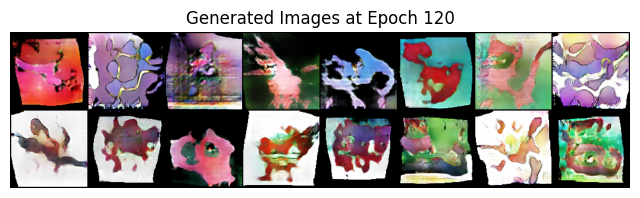

Epoch 121/300, Step 0, Loss D: 0.7123119235038757, Loss G: 2.392458438873291
Epoch 121/300, Step 50, Loss D: 0.6891951560974121, Loss G: 2.1057491302490234
Epoch 121/300, Step 100, Loss D: 0.6980148553848267, Loss G: 2.4288125038146973
Epoch 122/300, Step 0, Loss D: 0.7407715320587158, Loss G: 1.3581242561340332
Epoch 122/300, Step 50, Loss D: 0.8433215618133545, Loss G: 2.4183216094970703
Epoch 122/300, Step 100, Loss D: 0.8031055927276611, Loss G: 3.3862996101379395
Epoch 123/300, Step 0, Loss D: 0.7126283645629883, Loss G: 2.7848172187805176
Epoch 123/300, Step 50, Loss D: 0.6860706806182861, Loss G: 1.970881700515747
Epoch 123/300, Step 100, Loss D: 0.6790441274642944, Loss G: 1.657067060470581
Epoch 124/300, Step 0, Loss D: 0.6722118854522705, Loss G: 2.0519628524780273
Epoch 124/300, Step 50, Loss D: 0.6761756539344788, Loss G: 2.1170225143432617
Epoch 124/300, Step 100, Loss D: 0.7090911865234375, Loss G: 2.666853427886963
Epoch 125/300, Step 0, Loss D: 0.753314197063446, Loss G

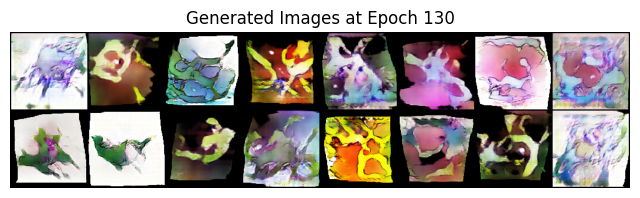

Epoch 131/300, Step 0, Loss D: 0.6877888441085815, Loss G: 2.6047983169555664
Epoch 131/300, Step 50, Loss D: 0.8381791710853577, Loss G: 2.4630255699157715
Epoch 131/300, Step 100, Loss D: 0.6884990930557251, Loss G: 2.0043277740478516
Epoch 132/300, Step 0, Loss D: 0.6767258644104004, Loss G: 1.7913702726364136
Epoch 132/300, Step 50, Loss D: 0.6852458715438843, Loss G: 1.9209915399551392
Epoch 132/300, Step 100, Loss D: 0.7833288311958313, Loss G: 1.5565681457519531
Epoch 133/300, Step 0, Loss D: 0.721562385559082, Loss G: 2.646151065826416
Epoch 133/300, Step 50, Loss D: 0.7345295548439026, Loss G: 1.9265484809875488
Epoch 133/300, Step 100, Loss D: 0.6833138465881348, Loss G: 2.604971408843994
Epoch 134/300, Step 0, Loss D: 0.6811457276344299, Loss G: 2.7618277072906494
Epoch 134/300, Step 50, Loss D: 0.74033522605896, Loss G: 2.1958706378936768
Epoch 134/300, Step 100, Loss D: 0.6696879267692566, Loss G: 1.9019032716751099
Epoch 135/300, Step 0, Loss D: 0.82502281665802, Loss G: 

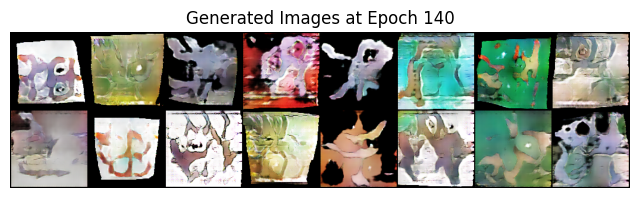

Epoch 141/300, Step 0, Loss D: 0.7226498126983643, Loss G: 2.535750150680542
Epoch 141/300, Step 50, Loss D: 0.7608234882354736, Loss G: 3.2991933822631836
Epoch 141/300, Step 100, Loss D: 0.8570752739906311, Loss G: 2.558743715286255
Epoch 142/300, Step 0, Loss D: 0.8627336621284485, Loss G: 1.3632125854492188
Epoch 142/300, Step 50, Loss D: 0.7903716564178467, Loss G: 3.0047879219055176
Epoch 142/300, Step 100, Loss D: 0.7059654593467712, Loss G: 2.5187573432922363
Epoch 143/300, Step 0, Loss D: 0.7505011558532715, Loss G: 1.1829376220703125
Epoch 143/300, Step 50, Loss D: 1.1402748823165894, Loss G: 0.47829610109329224
Epoch 143/300, Step 100, Loss D: 0.7485283017158508, Loss G: 3.193912982940674
Epoch 144/300, Step 0, Loss D: 0.689244270324707, Loss G: 2.5699689388275146
Epoch 144/300, Step 50, Loss D: 0.6922931671142578, Loss G: 2.068873167037964
Epoch 144/300, Step 100, Loss D: 0.6907668709754944, Loss G: 2.538510322570801
Epoch 145/300, Step 0, Loss D: 0.6920454502105713, Loss G

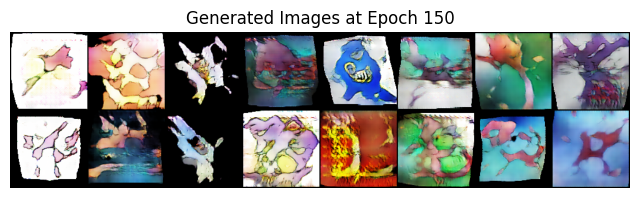

Epoch 151/300, Step 0, Loss D: 0.6728625297546387, Loss G: 2.006105661392212
Epoch 151/300, Step 50, Loss D: 0.6836341023445129, Loss G: 2.796839714050293
Epoch 151/300, Step 100, Loss D: 0.6670137047767639, Loss G: 2.2782111167907715
Epoch 152/300, Step 0, Loss D: 0.7098518013954163, Loss G: 2.297497034072876
Epoch 152/300, Step 50, Loss D: 0.6757413148880005, Loss G: 2.7558484077453613
Epoch 152/300, Step 100, Loss D: 0.9699445962905884, Loss G: 1.7025655508041382
Epoch 153/300, Step 0, Loss D: 0.695828914642334, Loss G: 1.7046968936920166
Epoch 153/300, Step 50, Loss D: 0.6722874641418457, Loss G: 2.4216558933258057
Epoch 153/300, Step 100, Loss D: 0.6817665100097656, Loss G: 2.4114513397216797
Epoch 154/300, Step 0, Loss D: 0.7357917428016663, Loss G: 3.214144229888916
Epoch 154/300, Step 50, Loss D: 0.8813388347625732, Loss G: 3.5971179008483887
Epoch 154/300, Step 100, Loss D: 0.687402606010437, Loss G: 2.119452714920044
Epoch 155/300, Step 0, Loss D: 0.6651840209960938, Loss G: 

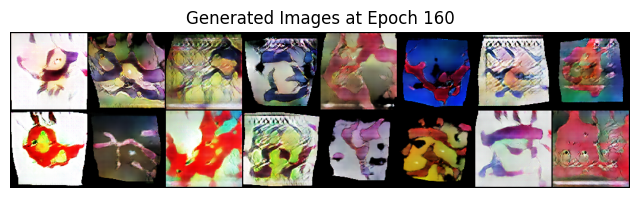

Epoch 161/300, Step 0, Loss D: 0.6821075081825256, Loss G: 2.052943706512451
Epoch 161/300, Step 50, Loss D: 0.6730424165725708, Loss G: 2.573803663253784
Epoch 161/300, Step 100, Loss D: 0.8487239480018616, Loss G: 3.5952420234680176
Epoch 162/300, Step 0, Loss D: 0.7169739007949829, Loss G: 2.110607385635376
Epoch 162/300, Step 50, Loss D: 0.7387175559997559, Loss G: 2.0740809440612793
Epoch 162/300, Step 100, Loss D: 0.7218683362007141, Loss G: 1.745064377784729
Epoch 163/300, Step 0, Loss D: 0.7079562544822693, Loss G: 1.6043434143066406
Epoch 163/300, Step 50, Loss D: 0.7189761400222778, Loss G: 2.2017664909362793
Epoch 163/300, Step 100, Loss D: 0.6940233111381531, Loss G: 2.3147964477539062
Epoch 164/300, Step 0, Loss D: 0.6926440596580505, Loss G: 2.382955551147461
Epoch 164/300, Step 50, Loss D: 0.709501326084137, Loss G: 2.6467652320861816
Epoch 164/300, Step 100, Loss D: 0.673675537109375, Loss G: 2.5687644481658936
Epoch 165/300, Step 0, Loss D: 0.806612491607666, Loss G: 2

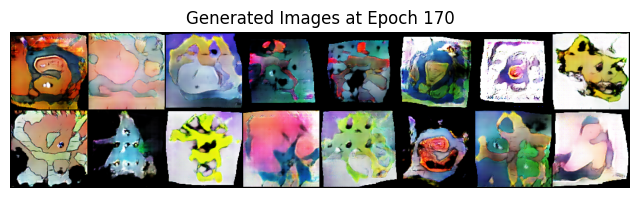

Epoch 171/300, Step 0, Loss D: 0.6881188154220581, Loss G: 2.754852533340454
Epoch 171/300, Step 50, Loss D: 0.6714427471160889, Loss G: 2.4697113037109375
Epoch 171/300, Step 100, Loss D: 0.6821179986000061, Loss G: 2.504936695098877
Epoch 172/300, Step 0, Loss D: 1.87826406955719, Loss G: 5.296375751495361
Epoch 172/300, Step 50, Loss D: 1.0453070402145386, Loss G: 3.322709560394287
Epoch 172/300, Step 100, Loss D: 0.7475218176841736, Loss G: 2.2360501289367676
Epoch 173/300, Step 0, Loss D: 0.6987234950065613, Loss G: 1.7815659046173096
Epoch 173/300, Step 50, Loss D: 0.7021743059158325, Loss G: 2.5161798000335693
Epoch 173/300, Step 100, Loss D: 0.6745531558990479, Loss G: 1.8601014614105225
Epoch 174/300, Step 0, Loss D: 0.6938461661338806, Loss G: 2.569638967514038
Epoch 174/300, Step 50, Loss D: 0.6995301842689514, Loss G: 2.7860043048858643
Epoch 174/300, Step 100, Loss D: 0.6709943413734436, Loss G: 2.4131672382354736
Epoch 175/300, Step 0, Loss D: 0.6656515598297119, Loss G: 

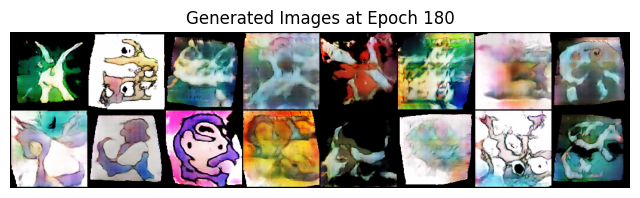

Epoch 181/300, Step 0, Loss D: 0.6841375231742859, Loss G: 2.3106637001037598
Epoch 181/300, Step 50, Loss D: 0.7018018364906311, Loss G: 2.705577850341797
Epoch 181/300, Step 100, Loss D: 0.8263236284255981, Loss G: 2.2783074378967285
Epoch 182/300, Step 0, Loss D: 0.6776485443115234, Loss G: 2.1653685569763184
Epoch 182/300, Step 50, Loss D: 0.6875592470169067, Loss G: 2.7079014778137207
Epoch 182/300, Step 100, Loss D: 0.7321388125419617, Loss G: 1.041388750076294
Epoch 183/300, Step 0, Loss D: 0.6694338321685791, Loss G: 2.3080523014068604
Epoch 183/300, Step 50, Loss D: 0.7069727182388306, Loss G: 2.1609303951263428
Epoch 183/300, Step 100, Loss D: 0.6981168985366821, Loss G: 1.9854967594146729
Epoch 184/300, Step 0, Loss D: 0.6898298263549805, Loss G: 2.029144763946533
Epoch 184/300, Step 50, Loss D: 0.6848938465118408, Loss G: 2.2225003242492676
Epoch 184/300, Step 100, Loss D: 0.6843596696853638, Loss G: 2.147561550140381
Epoch 185/300, Step 0, Loss D: 0.7611986398696899, Loss 

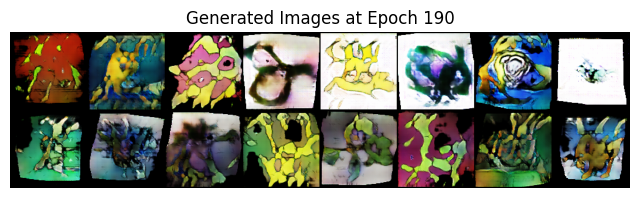

Epoch 191/300, Step 0, Loss D: 0.666999101638794, Loss G: 2.097163200378418
Epoch 191/300, Step 50, Loss D: 0.7029496431350708, Loss G: 2.2313284873962402
Epoch 191/300, Step 100, Loss D: 0.7684065103530884, Loss G: 2.741671323776245
Epoch 192/300, Step 0, Loss D: 0.6698240637779236, Loss G: 2.1348204612731934
Epoch 192/300, Step 50, Loss D: 0.6669328212738037, Loss G: 1.8605620861053467
Epoch 192/300, Step 100, Loss D: 0.6939541101455688, Loss G: 2.189668655395508
Epoch 193/300, Step 0, Loss D: 0.6657809615135193, Loss G: 2.6727023124694824
Epoch 193/300, Step 50, Loss D: 0.6806557178497314, Loss G: 2.715921640396118
Epoch 193/300, Step 100, Loss D: 0.7078440189361572, Loss G: 2.8503785133361816
Epoch 194/300, Step 0, Loss D: 0.7322347164154053, Loss G: 1.6531264781951904
Epoch 194/300, Step 50, Loss D: 0.6652919054031372, Loss G: 2.275573253631592
Epoch 194/300, Step 100, Loss D: 0.7330695390701294, Loss G: 1.8930573463439941
Epoch 195/300, Step 0, Loss D: 0.6650277376174927, Loss G:

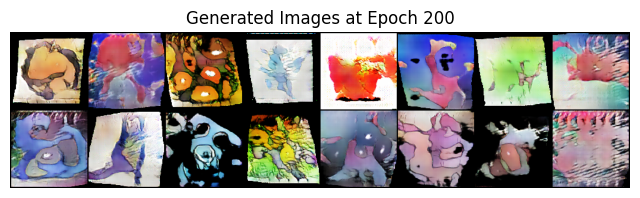

Epoch 201/300, Step 0, Loss D: 0.732001543045044, Loss G: 2.871535539627075
Epoch 201/300, Step 50, Loss D: 1.236891508102417, Loss G: 2.5068254470825195
Epoch 201/300, Step 100, Loss D: 0.6842449307441711, Loss G: 1.6649492979049683
Epoch 202/300, Step 0, Loss D: 0.6876983642578125, Loss G: 1.8248711824417114
Epoch 202/300, Step 50, Loss D: 0.7429921627044678, Loss G: 1.5380642414093018
Epoch 202/300, Step 100, Loss D: 0.691457986831665, Loss G: 1.8958208560943604
Epoch 203/300, Step 0, Loss D: 0.6983968019485474, Loss G: 1.9944860935211182
Epoch 203/300, Step 50, Loss D: 0.6871905326843262, Loss G: 2.713902473449707
Epoch 203/300, Step 100, Loss D: 0.6857016086578369, Loss G: 2.5180487632751465
Epoch 204/300, Step 0, Loss D: 0.6659791469573975, Loss G: 2.440256357192993
Epoch 204/300, Step 50, Loss D: 0.6676174402236938, Loss G: 2.385660171508789
Epoch 204/300, Step 100, Loss D: 0.6655417084693909, Loss G: 2.211007595062256
Epoch 205/300, Step 0, Loss D: 0.7403571605682373, Loss G: 2

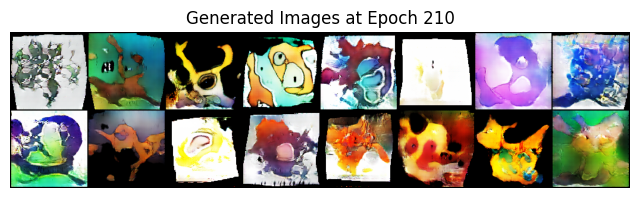

Epoch 211/300, Step 0, Loss D: 0.6949505805969238, Loss G: 2.406195640563965
Epoch 211/300, Step 50, Loss D: 0.6783387660980225, Loss G: 2.20989990234375
Epoch 211/300, Step 100, Loss D: 0.6944557428359985, Loss G: 2.1734509468078613
Epoch 212/300, Step 0, Loss D: 0.6665410995483398, Loss G: 2.0128684043884277
Epoch 212/300, Step 50, Loss D: 0.6695494055747986, Loss G: 2.131906032562256
Epoch 212/300, Step 100, Loss D: 0.7159545421600342, Loss G: 1.8288549184799194
Epoch 213/300, Step 0, Loss D: 0.674841582775116, Loss G: 1.9285941123962402
Epoch 213/300, Step 50, Loss D: 0.7011051177978516, Loss G: 2.753849744796753
Epoch 213/300, Step 100, Loss D: 0.6808008551597595, Loss G: 1.9073798656463623
Epoch 214/300, Step 0, Loss D: 1.4135667085647583, Loss G: 3.7448208332061768
Epoch 214/300, Step 50, Loss D: 0.6809282302856445, Loss G: 2.2055115699768066
Epoch 214/300, Step 100, Loss D: 0.733166515827179, Loss G: 2.433617115020752
Epoch 215/300, Step 0, Loss D: 0.6797250509262085, Loss G: 2

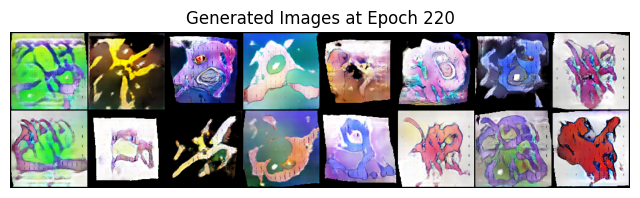

Epoch 221/300, Step 0, Loss D: 0.6672754287719727, Loss G: 2.1268484592437744
Epoch 221/300, Step 50, Loss D: 0.7028940916061401, Loss G: 2.6040453910827637
Epoch 221/300, Step 100, Loss D: 0.6671485304832458, Loss G: 2.170524835586548
Epoch 222/300, Step 0, Loss D: 0.6693233251571655, Loss G: 2.1907002925872803
Epoch 222/300, Step 50, Loss D: 0.6850121021270752, Loss G: 2.3410301208496094
Epoch 222/300, Step 100, Loss D: 0.6771311163902283, Loss G: 2.320873975753784
Epoch 223/300, Step 0, Loss D: 0.7756261825561523, Loss G: 1.800800085067749
Epoch 223/300, Step 50, Loss D: 0.6844199895858765, Loss G: 2.5110273361206055
Epoch 223/300, Step 100, Loss D: 0.6924710273742676, Loss G: 2.2721805572509766
Epoch 224/300, Step 0, Loss D: 0.6639561653137207, Loss G: 2.2470498085021973
Epoch 224/300, Step 50, Loss D: 0.6706463098526001, Loss G: 1.9643702507019043
Epoch 224/300, Step 100, Loss D: 0.7185094356536865, Loss G: 1.9691232442855835
Epoch 225/300, Step 0, Loss D: 0.6919243335723877, Loss

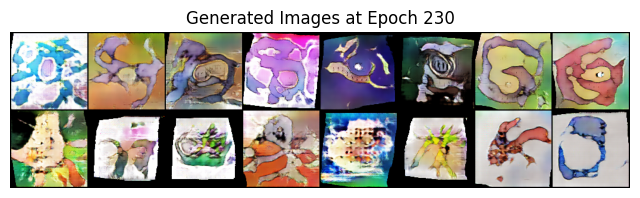

Epoch 231/300, Step 0, Loss D: 0.7564878463745117, Loss G: 1.8814549446105957
Epoch 231/300, Step 50, Loss D: 0.6714065670967102, Loss G: 1.9829292297363281
Epoch 231/300, Step 100, Loss D: 0.6997829675674438, Loss G: 2.4615378379821777
Epoch 232/300, Step 0, Loss D: 0.7032415866851807, Loss G: 2.8377208709716797
Epoch 232/300, Step 50, Loss D: 0.7322943210601807, Loss G: 2.227274179458618
Epoch 232/300, Step 100, Loss D: 0.7454975843429565, Loss G: 2.533700466156006
Epoch 233/300, Step 0, Loss D: 0.6748815774917603, Loss G: 2.3926475048065186
Epoch 233/300, Step 50, Loss D: 0.6633483171463013, Loss G: 2.2505691051483154
Epoch 233/300, Step 100, Loss D: 0.6706900596618652, Loss G: 2.6043267250061035
Epoch 234/300, Step 0, Loss D: 1.1459146738052368, Loss G: 3.767592430114746
Epoch 234/300, Step 50, Loss D: 0.6743661165237427, Loss G: 2.156278371810913
Epoch 234/300, Step 100, Loss D: 0.6645240783691406, Loss G: 2.282304525375366
Epoch 235/300, Step 0, Loss D: 0.6992694735527039, Loss G

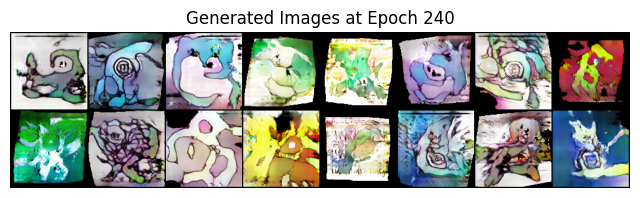

Epoch 241/300, Step 0, Loss D: 0.9556823968887329, Loss G: 3.7451000213623047
Epoch 241/300, Step 50, Loss D: 0.8746154308319092, Loss G: 2.199152708053589
Epoch 241/300, Step 100, Loss D: 0.6898095011711121, Loss G: 1.7039237022399902
Epoch 242/300, Step 0, Loss D: 0.6880570650100708, Loss G: 2.1200618743896484
Epoch 242/300, Step 50, Loss D: 0.6687256097793579, Loss G: 1.9463050365447998
Epoch 242/300, Step 100, Loss D: 0.6935793161392212, Loss G: 2.529482841491699
Epoch 243/300, Step 0, Loss D: 0.6823220252990723, Loss G: 2.350518226623535
Epoch 243/300, Step 50, Loss D: 0.6624146103858948, Loss G: 2.154747724533081
Epoch 243/300, Step 100, Loss D: 0.7038218379020691, Loss G: 2.432136297225952
Epoch 244/300, Step 0, Loss D: 0.788428544998169, Loss G: 3.326564311981201
Epoch 244/300, Step 50, Loss D: 0.7450253963470459, Loss G: 2.4018847942352295
Epoch 244/300, Step 100, Loss D: 0.6642831563949585, Loss G: 2.363802433013916
Epoch 245/300, Step 0, Loss D: 0.674589991569519, Loss G: 2.

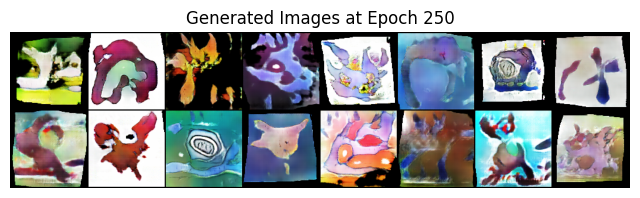

Epoch 251/300, Step 0, Loss D: 0.6671757698059082, Loss G: 2.2792584896087646
Epoch 251/300, Step 50, Loss D: 0.676593005657196, Loss G: 2.20723295211792
Epoch 251/300, Step 100, Loss D: 1.013580560684204, Loss G: 1.957043170928955
Epoch 252/300, Step 0, Loss D: 0.7876050472259521, Loss G: 2.132798671722412
Epoch 252/300, Step 50, Loss D: 0.718275249004364, Loss G: 1.8463314771652222
Epoch 252/300, Step 100, Loss D: 0.7296041250228882, Loss G: 2.162994384765625
Epoch 253/300, Step 0, Loss D: 0.7214081883430481, Loss G: 2.396169662475586
Epoch 253/300, Step 50, Loss D: 0.7404807806015015, Loss G: 1.9023137092590332
Epoch 253/300, Step 100, Loss D: 0.6739645600318909, Loss G: 1.8684691190719604
Epoch 254/300, Step 0, Loss D: 0.7045952677726746, Loss G: 2.3411660194396973
Epoch 254/300, Step 50, Loss D: 0.6673324108123779, Loss G: 2.006051540374756
Epoch 254/300, Step 100, Loss D: 0.6712899804115295, Loss G: 2.019850254058838
Epoch 255/300, Step 0, Loss D: 0.6798510551452637, Loss G: 1.84

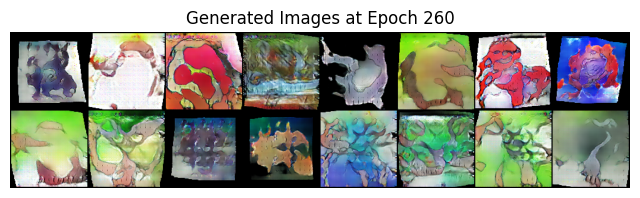

Epoch 261/300, Step 0, Loss D: 0.6660504937171936, Loss G: 2.1376705169677734
Epoch 261/300, Step 50, Loss D: 0.6912893056869507, Loss G: 2.1514790058135986
Epoch 261/300, Step 100, Loss D: 0.6760746240615845, Loss G: 2.0079264640808105
Epoch 262/300, Step 0, Loss D: 0.8973410725593567, Loss G: 1.0323388576507568
Epoch 262/300, Step 50, Loss D: 0.6773467063903809, Loss G: 2.0745930671691895
Epoch 262/300, Step 100, Loss D: 0.6836445927619934, Loss G: 2.4373416900634766
Epoch 263/300, Step 0, Loss D: 0.7064752578735352, Loss G: 2.0763702392578125
Epoch 263/300, Step 50, Loss D: 0.7203558087348938, Loss G: 3.0642619132995605
Epoch 263/300, Step 100, Loss D: 0.6761252880096436, Loss G: 2.2567927837371826
Epoch 264/300, Step 0, Loss D: 0.6760393977165222, Loss G: 2.3152382373809814
Epoch 264/300, Step 50, Loss D: 0.6892458200454712, Loss G: 2.220426082611084
Epoch 264/300, Step 100, Loss D: 0.6616414785385132, Loss G: 2.152522563934326
Epoch 265/300, Step 0, Loss D: 0.6625616550445557, Los

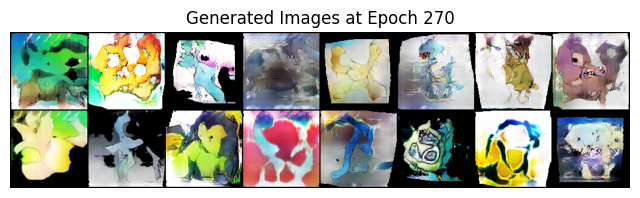

Epoch 271/300, Step 0, Loss D: 1.300678014755249, Loss G: 4.086029052734375
Epoch 271/300, Step 50, Loss D: 0.750163733959198, Loss G: 3.250826597213745
Epoch 271/300, Step 100, Loss D: 0.6852481365203857, Loss G: 1.6499946117401123
Epoch 272/300, Step 0, Loss D: 0.675585150718689, Loss G: 2.4463791847229004
Epoch 272/300, Step 50, Loss D: 0.783796489238739, Loss G: 1.3965873718261719
Epoch 272/300, Step 100, Loss D: 0.7083903551101685, Loss G: 2.3347558975219727
Epoch 273/300, Step 0, Loss D: 0.768710196018219, Loss G: 2.7089743614196777
Epoch 273/300, Step 50, Loss D: 0.6646052598953247, Loss G: 2.1356256008148193
Epoch 273/300, Step 100, Loss D: 0.8669928312301636, Loss G: 3.8775036334991455
Epoch 274/300, Step 0, Loss D: 0.860224187374115, Loss G: 2.4395551681518555
Epoch 274/300, Step 50, Loss D: 0.6847559213638306, Loss G: 2.4543380737304688
Epoch 274/300, Step 100, Loss D: 0.6628810167312622, Loss G: 2.42488956451416
Epoch 275/300, Step 0, Loss D: 0.7857258319854736, Loss G: 2.0

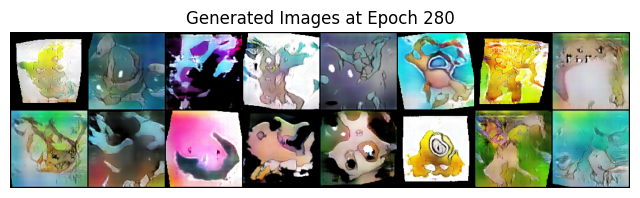

Epoch 281/300, Step 0, Loss D: 0.83152174949646, Loss G: 1.014238953590393
Epoch 281/300, Step 50, Loss D: 0.6753796935081482, Loss G: 2.0951414108276367
Epoch 281/300, Step 100, Loss D: 0.6727215051651001, Loss G: 2.2213523387908936
Epoch 282/300, Step 0, Loss D: 0.6668015718460083, Loss G: 2.1413588523864746
Epoch 282/300, Step 50, Loss D: 0.6635254621505737, Loss G: 2.1613924503326416
Epoch 282/300, Step 100, Loss D: 0.6784188747406006, Loss G: 2.1487960815429688
Epoch 283/300, Step 0, Loss D: 0.6802070140838623, Loss G: 1.8751084804534912
Epoch 283/300, Step 50, Loss D: 0.6797730326652527, Loss G: 2.003436326980591
Epoch 283/300, Step 100, Loss D: 0.6738572120666504, Loss G: 2.4750704765319824
Epoch 284/300, Step 0, Loss D: 0.8558976650238037, Loss G: 3.194892168045044
Epoch 284/300, Step 50, Loss D: 0.7071553468704224, Loss G: 1.6876250505447388
Epoch 284/300, Step 100, Loss D: 0.6735262870788574, Loss G: 2.2496087551116943
Epoch 285/300, Step 0, Loss D: 0.6979312896728516, Loss G

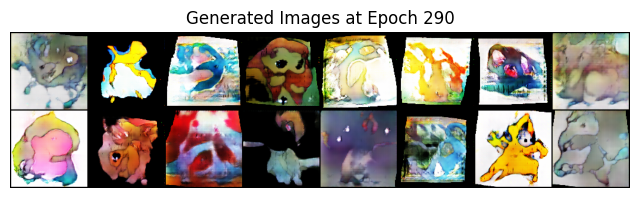

Epoch 291/300, Step 0, Loss D: 0.7620981335639954, Loss G: 2.0678060054779053
Epoch 291/300, Step 50, Loss D: 0.6988176107406616, Loss G: 2.5226006507873535
Epoch 291/300, Step 100, Loss D: 0.6782412528991699, Loss G: 2.1911911964416504
Epoch 292/300, Step 0, Loss D: 0.6692938804626465, Loss G: 2.5007128715515137
Epoch 292/300, Step 50, Loss D: 0.6674884557723999, Loss G: 2.292585849761963
Epoch 292/300, Step 100, Loss D: 0.7667565941810608, Loss G: 1.6765882968902588
Epoch 293/300, Step 0, Loss D: 0.6966784000396729, Loss G: 2.369924783706665
Epoch 293/300, Step 50, Loss D: 0.6801886558532715, Loss G: 2.526456356048584
Epoch 293/300, Step 100, Loss D: 0.6638505458831787, Loss G: 1.9767415523529053
Epoch 294/300, Step 0, Loss D: 0.6624428033828735, Loss G: 2.2369985580444336
Epoch 294/300, Step 50, Loss D: 0.674740731716156, Loss G: 2.093437671661377
Epoch 294/300, Step 100, Loss D: 0.6858798861503601, Loss G: 2.0098812580108643
Epoch 295/300, Step 0, Loss D: 0.6767245531082153, Loss G

In [56]:
num_epochs = 300
real_label = 0.9
fake_label = 0.1

G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Train Discriminator
        discriminator.zero_grad()
        real_images = real_images.to("cuda")
        b_size = real_images.size(0)

        # Fix label shape
        label = torch.full((b_size, 1), real_label, dtype=torch.float, device="cuda")

        # Forward pass real batch
        output = discriminator(real_images)  # Now shape is (b_size, 1)
        lossD_real = criterion(output, label)
        lossD_real.backward()

        # Generate fake images
        noise = torch.randn(b_size, nz, 1, 1, device="cuda")
        fake_images = generator(noise)
        label.fill_(fake_label)

        # Forward pass fake batch
        output = discriminator(fake_images.detach())  # Now shape is (b_size, 1)
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        optimizer_D.step()

        # Train Generator
        generator.zero_grad()
        label.fill_(real_label)  # Generator tries to fool Discriminator
        output = discriminator(fake_images)  # Now shape is (b_size, 1)
        lossG = criterion(output, label)
        lossG.backward()
        optimizer_G.step()


        if i % 50 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Step {i}, Loss D: {lossD_real + lossD_fake}, Loss G: {lossG}")

    G_losses.append(lossG.item())
    D_losses.append(lossD_real.item() + lossD_fake.item())

    if epoch % 10 == 0:
        with torch.no_grad():
          show_generated_images(epoch)


In [57]:
# Save the Generator model
torch.save(generator.state_dict(), "dcgan_pokemon_generator.pth")

# Save the Discriminator model (optional)
torch.save(discriminator.state_dict(), "dcgan_pokemon_discriminator.pth")


In [58]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

# Save the trained model to Google Drive
model_path = "/content/drive/MyDrive/dcgan_pokemon_generator.pth"
torch.save(generator.state_dict(), model_path)
print(f"Model saved to {model_path}")


Mounted at /content/drive
Model saved to /content/drive/MyDrive/dcgan_pokemon_generator.pth


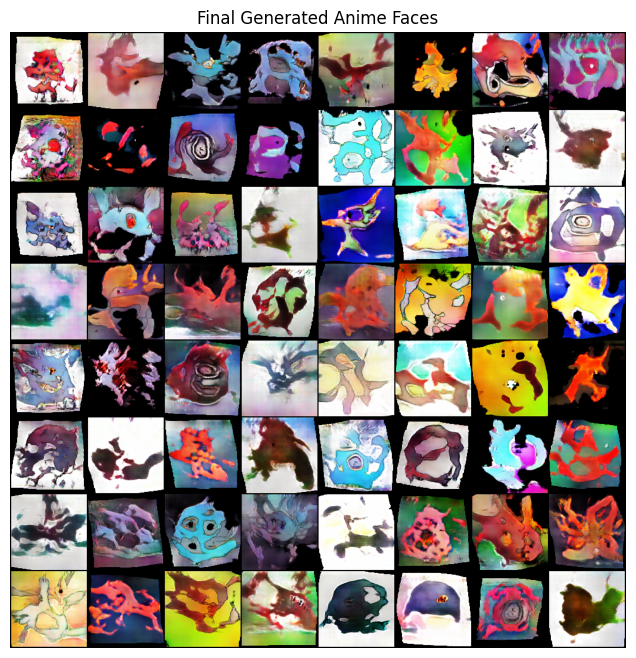

In [59]:
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Final Generated Anime Faces")
plt.imshow(vutils.make_grid(fake_images, padding=2, normalize=True).permute(1, 2, 0))
plt.show()


In [65]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from ipywidgets import Button, Output
from IPython.display import display

# Latent vector size
nz = 512
nc = 3  # RGB images
ngf = 256  # Generator feature maps

# ✅ Corrected Generator Architecture (Matches Trained Model)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# ✅ Load Trained Model with Correct Architecture
device = "cuda" if torch.cuda.is_available() else "cpu"
netG = Generator().to(device)

# ✅ Load the correct trained weights
model_path = "dcgan_pokemon_generator.pth"  # Ensure correct path
try:
    netG.load_state_dict(torch.load(model_path, map_location=device))
    netG.eval()
    print("✅ Generator model loaded successfully!")
except FileNotFoundError:
    print("❌ Model file not found! Please check the path.")

# ✅ Create button and output widget
button = Button(description="Generate Pokémon")
output = Output()

def generate_pokemon(_):
    """Generates and displays a Pokémon image when the button is clicked."""
    noise = torch.randn(1, nz, 1, 1, device=device)  # ✅ Using correct nz = 512
    with torch.no_grad():
        fake_image = netG(noise).detach().cpu()

    # Convert tensor to numpy for correct display
    img = vutils.make_grid(fake_image, normalize=True, scale_each=True).permute(1, 2, 0).numpy()

    # ✅ Display the generated Pokémon (High Quality)
    with output:
        output.clear_output(wait=True)
        plt.figure(figsize=(4, 4), dpi=150)  # Increased DPI for sharper images
        plt.axis("off")
        plt.title("Generated Pokémon")
        plt.imshow(img, interpolation='nearest')  # Prevents blurring
        plt.show()

# ✅ Attach button click event
button.on_click(generate_pokemon)

# ✅ Display button and output area
display(button, output)


✅ Generator model loaded successfully!


Button(description='Generate Pokémon', style=ButtonStyle())

Output()